In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Process for Making a Prediction

A lot is written about how to tune specific time series forecasting models, but little help is given
to how to use a model to make predictions. Once you can build and tune forecast models for
your data, the process of making a prediction involves the following steps:
1. Model Selection. This is where you choose a model and gather evidence and support to defend the decision.
2. Model Finalization. The chosen model is trained on all available data and saved to file for later use.
3. Forecasting. The saved model is loaded and used to make a forecast.
4. Model Update. Elements of the model are updated in the presence of new observations.

We will take a look at each of these elements in this tutorial, with a focus on saving and
loading the model to and from file and using a loaded model to make predictions. Before we
dive in, let's first look at a standard univariate dataset that we can use as the context for this
tutorial.

In [2]:
df = pd.read_csv('./dataset/daily-total-female-births.csv', parse_dates=['Date'], index_col='Date')
df.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


### Select Time Series Forecast Model

You must select a model. This is where the bulk of the effort will be in preparing the data,
performing analysis, and ultimately selecting a model and model hyperparameters that best
capture the relationships in the data. In this case, we can arbitrarily select an autoregression
model (AR) with a lag of 6 on the differenced dataset. We can demonstrate this model below.
First, the data is transformed by differencing, with each observation transformed as:

$$value(t) = obs(t) - obs(t-1)$$

train: 76, test: 72
train: 148, test: 72
train: 220, test: 72
train: 292, test: 72
Test RMSE: 6.763


C:\Users\Angga\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


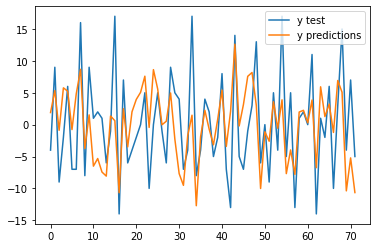

In [3]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

# create a difference transform of the dataset
df['Diff'] = df.iloc[:, 0].diff()

# Make a prediction give regression coefficients and lag obs
def predict(coef, history):
    y_pred = coef[0]
    for i in range(1, len(coef)):
        y_pred += coef[i] * history[-i]
    return y_pred

# split dataset
X = df['Diff'].values[1:]
splits = TimeSeriesSplit(n_splits=4)
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print(f'train: {len(train)}, test: {len(test)}')
    
# train autoregression
window_size = 6
model = AR(train[1:])
model_fit = model.fit(maxlag=window_size, disp=False)
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = [i for i in train]
predictions = []
history
for t in range(len(test)):
    y_pred = predict(coef, history)
    obs = test[t]
    predictions.append(y_pred)
    history.append(obs)
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


plt.plot(test, label='y test')
plt.plot(predictions, label='y predictions')
plt.legend()
plt.show()

# display(train.head())
# display(test.head())

## Finalize and Save Time Series Forecast Model

Once the model is selected, we must finalize it. This means save the salient information learned
by the model so that we do not have to re-create it every time a prediction is needed. This
involves first training the model on all available data and then saving the model to file.
The Statsmodels implementations of time series models do provide built-in capability to
save and load models by calling save() and load() on the fit ARResults object1. For example,
the code below will train an AR(6) model on the entire Female Births dataset and save it using
the built-in save() function, which will essentially pickle the ARResults object.

In [4]:
model = AR(X)
model_fit = model.fit(maxlag=6, disp=False)

# save model to file
model_fit.save('./model/ar_model.pkl')

# save the differenced dataset
np.save('./model/ar_data.npy', X)

# save the last ob
np.save('./model/ar_obs.npy', [df['Births'].values[-1]])

C:\Users\Angga\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


In [5]:
from statsmodels.tsa.ar_model import ARResults

loaded = ARResults.load('./model/ar_model.pkl')
print(loaded.params)
data = np.load('./model/ar_data.npy')
print(data)
last_ob = np.load('./model/ar_obs.npy')
print(last_ob)

[ 0.12129822 -0.75275857 -0.612367   -0.51097172 -0.4176669  -0.32116469
 -0.23412997]
[ -3.  -2.   1.  13. -15.  16.  -2.  -5. -11.  11.  -5.  22.  -8.  -2.
  -8.  13.  -7.  -2.  11. -18.  19. -14.  -7.   5.   6.  -4.  -4.   9.
  -6. -14.  -1.   8.  13.  -6.  12. -12.  13. -20.   0.  20. -15.   9.
   6. -17.  18.  -5.  -2.   1.  -7.   9. -11.  -2.  17. -10.   3.  -6.
  -2.  -7.   5.  -7.  17. -11.   2.  14.  -6.  -5.  -7.   7.   6.  -2.
  -4.  -8.  -4.   3.  12.   4.  -5.  -5.   9.   1.  -3.  -5.  -4.   1.
  21. -20.  -4.  18.  -9.  -2.   2.   6. -13.   2.  -3.   2.   3.   0.
  -4.  19. -19.   0.   4.  -3.  -3.  10.  -8.  12. -16.  16.  -1.   9.
 -20.   3.  -2.   5.   2.  16.  -7. -19.   3.   3.  -5.   6.   8.  -9.
  14. -22.   4.   6.  -5.   7.  -1.   1.  -4. -14.  10.   9.  -7.  19.
 -14.   4.  -4.  -4.   6.  -4.  -6.  10.  -3.  -2.   7.   1. -12.   1.
  13.   3. -15.  -3.  13.  -4.   6. -14.   7.  -6.   5.  -6.  -4.   6.
   4.  -1.   6.  -7.   9. -14.  -3.  12.   1.  -2.   0.  18. 

In [6]:
# save coefficients
np.save('./model/man_model.npy', coef)

# save lag
lag = X[-window_size:]
np.save('./model/man_data.npy', lag)

# save the last obs 
np.save('./model/man_obs.npy', [df['Births'].values[-1]])

In [7]:
# load the manually saved model from file
coef = np.load('./model/man_model.npy')
print(coef)
lag = np.load('./model/man_data.npy')
print(lag)
last_ob = np.load('./model/man_obs.npy')
print(last_ob)

[ 0.09443461 -0.78700366 -0.65606609 -0.56755848 -0.47451243 -0.3620022
 -0.25763837]
[-10.   3.  15.  -4.   7.  -5.]
[50]


## Make a Time Series Forecast

Making a forecast involves loading the saved model and estimating the observation at the next
time step. If the ARResults object was serialized, we can use the predict() function to predict
the next time period. The example below shows how the next time period can be predicted.
The model, training data, and last observation are loaded from file.

The period is specified to the predict() function as the next time index after the end of
the training data set. This index may be stored directly in a file instead of storing the entire
training data, which may be an eficiency. The prediction is made, which is in the context of
the differenced dataset. To turn the prediction back into the original units, it must be added to
the last known observation.

In [8]:
# load AR model from file and make a one-step prediction
from statsmodels.tsa.ar_model import ARResults

# load model
model = ARResults.load('./model/ar_model.pkl')
data = np.load('./model/ar_data.npy')
last_ob = np.load('./model/ar_obs.npy')

# make prediction
predictions = model.predict(start=len(data), end=len(data))

# transform prediction
yhat = predictions[0] + last_ob[0]
print('Prediction: %f' % yhat)

Prediction: 46.755211


In [9]:
# load a coefficients and from file and make a manual prediction
import numpy
def predict(coef, history):
    yhat = coef[0]
    for i in range(1, len(coef)):
        yhat += coef[i] * history[-i]
    return yhat
# load model
coef = np.load('./model/man_model.npy')
lag = np.load('./model/man_data.npy')
last_ob = np.load('./model/man_obs.npy')
# make prediction
prediction = predict(coef, lag)
# transform prediction
yhat = prediction + last_ob[0]
print('Prediction: %f' % yhat)

Prediction: 46.079915


## Update Forecast Model

Our work is not done. Once the next real observation is made available, we must update the
data associated with the model. Specifically, we must update:
1. The differenced training dataset used as inputs to make the subsequent prediction.
2. The last observation, providing a context for the predicted differenced value.

Let's assume the next actual observation in the series was 48. The new observation must
first be differenced with the last observation. It can then be stored in the list of dierenced
observations. Finally, the value can be stored as the last observation.
In the case of the stored AR model, we can update the ar data.npy and ar obs.npy files.
The complete example is listed below:

In [20]:
# get real observations
observations = 48

# load the saved data
data = np.load('./model/ar_data.npy')
last_obs = np.load('./model/ar_obs.npy')

# update and save differenced observation
diffed = observations - last_obs[0]
data = np.append(data, diffed)

np.save('./model/ar_data_updated.npy', data)
last_obs[0] = observations
np.save('./model/ar_obs_updated.npy', last_obs)

In [24]:
new_data = np.load('./model/ar_data_updated.npy')
print(new_data)
new_obs = np.load('./model/ar_obs_updated.npy')
print(new_obs)

[ -3.  -2.   1.  13. -15.  16.  -2.  -5. -11.  11.  -5.  22.  -8.  -2.
  -8.  13.  -7.  -2.  11. -18.  19. -14.  -7.   5.   6.  -4.  -4.   9.
  -6. -14.  -1.   8.  13.  -6.  12. -12.  13. -20.   0.  20. -15.   9.
   6. -17.  18.  -5.  -2.   1.  -7.   9. -11.  -2.  17. -10.   3.  -6.
  -2.  -7.   5.  -7.  17. -11.   2.  14.  -6.  -5.  -7.   7.   6.  -2.
  -4.  -8.  -4.   3.  12.   4.  -5.  -5.   9.   1.  -3.  -5.  -4.   1.
  21. -20.  -4.  18.  -9.  -2.   2.   6. -13.   2.  -3.   2.   3.   0.
  -4.  19. -19.   0.   4.  -3.  -3.  10.  -8.  12. -16.  16.  -1.   9.
 -20.   3.  -2.   5.   2.  16.  -7. -19.   3.   3.  -5.   6.   8.  -9.
  14. -22.   4.   6.  -5.   7.  -1.   1.  -4. -14.  10.   9.  -7.  19.
 -14.   4.  -4.  -4.   6.  -4.  -6.  10.  -3.  -2.   7.   1. -12.   1.
  13.   3. -15.  -3.  13.  -4.   6. -14.   7.  -6.   5.  -6.  -4.   6.
   4.  -1.   6.  -7.   9. -14.  -3.  12.   1.  -2.   0.  18. -16.   2.
  -7.  -1.   8.  -3.  15. -11.   5. -10.   6. -21.   9.   9.  -3.   1.
  -6. 

In [30]:
# update the data for the manual model with a new obs
import numpy
# get real observation
observation = 48
# update and save differenced observation
lag = numpy.load('./model/man_data.npy')
last_obs = numpy.load('./model/man_obs.npy')

diffed = observation - last_obs[0]
lag = np.append(lag[1:], [diffed], axis=0)
np.save('./model/man_data_updated.npy', lag)

# update and save real observation
last_obs[0] = observation
np.save('./model/man_obs_updated.npy', last_obs)

In [34]:
new_data = np.load('./model/man_data_updated.npy')
print(new_data)
new_obs = np.load('./model/man_obs_updated.npy')
print(new_obs)

[ 3. 15. -4.  7. -5. -2.]
[48]
